In [1]:
# !pip install torch==2.7.1+cpu torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install pandas==2.2.3 scikit-learn==1.6.1 evaluate==0.4.3 datasets==3.0.1 matplotlib
# !pip install transformers==4.54.1 accelerate==1.10.1
#!pip install pandas numpy matplotlib seaborn matplotlib plotly plotly_express scikit-learn plotly imbalanced-learn
#%pip install joypy

In [2]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModel
import csv
import os
import re
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.ticker import MaxNLocator
from scipy.stats import shapiro,  mannwhitneyu
from scipy.stats import spearmanr
import pandas as pd

In [3]:
def convertList(df):
    def parse_probs(x):
        if isinstance(x, str):
            x = re.sub(r'\s+', ',', x.strip('[] '))
            return np.fromstring(x, sep=',')
        elif isinstance(x, (list, np.ndarray)):
            return np.array(x)
        else:
            return np.array([np.nan, np.nan])    
    df['probs_list'] = df['toxicity_probs'].apply(parse_probs)
    df[['not_toxic_prob', 'toxic_prob']] = pd.DataFrame(df['probs_list'].tolist(), index=df.index)
    return df

In [4]:
def compute_toxicity_score(row):
    return row['toxic']

In [5]:
df_2020 = pd.read_csv("analysis/2020_toxicity_results.csv")
df_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191798 entries, 0 to 191797
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   label           191798 non-null  object 
 1   tweet           191798 non-null  object 
 2   toxicity_label  191798 non-null  object 
 3   toxicity_probs  191798 non-null  object 
 4   non-toxic       191798 non-null  float64
 5   toxic           191798 non-null  float64
dtypes: float64(2), object(4)
memory usage: 8.8+ MB


In [6]:
df_2024 = pd.read_csv("analysis/2024_toxicity_results_0.csv")
df_2024.info()
df_2024.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191798 entries, 0 to 191797
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   label           191798 non-null  object 
 1   tweet           191798 non-null  object 
 2   toxicity_label  191798 non-null  object 
 3   non-toxic       191798 non-null  float64
 4   toxic           191798 non-null  float64
 5   toxicity_probs  191798 non-null  object 
dtypes: float64(2), object(4)
memory usage: 8.8+ MB


,label,tweet,toxicity_label,non-toxic,toxic,toxicity_probs
0,Left,@ USER Fuck Joe Biden fuck Ukraine fuck the De...,toxic,0.000801,0.999199,[8.0052856e-04 9.9919945e-01]
1,Right,Fly them back to their home country just like ...,toxic,0.002000,0.998000,[0.00199954 0.99800044]
2,Right,Wow ! I ca n't believe the @ USER . They 're s...,toxic,0.008005,0.991995,[0.00800453 0.99199545]
3,Right,@ USER @ USER @ USER The election be rig again...,non-toxic,0.982618,0.017382,[0.98261833 0.01738162]
4,Right,@ USER @ USER @ USER @ USER @ USER Why be acto...,non-toxic,0.972511,0.027489,[0.9725112 0.02748879]


In [7]:
df_2020 = pd.read_csv("analysis/2020_toxicity_results.csv")
df_2020 = convertList(df_2020)
df_2020['year'] = 2020
df_2020['group'] = df_2020['label'] + " " + df_2020['year'].astype(str)
df_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191798 entries, 0 to 191797
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   label           191798 non-null  object 
 1   tweet           191798 non-null  object 
 2   toxicity_label  191798 non-null  object 
 3   toxicity_probs  191798 non-null  object 
 4   non-toxic       191798 non-null  float64
 5   toxic           191798 non-null  float64
 6   probs_list      191798 non-null  object 
 7   not_toxic_prob  191798 non-null  float64
 8   toxic_prob      191798 non-null  float64
 9   year            191798 non-null  int64  
 10  group           191798 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 16.1+ MB


In [8]:
df_2020.head(2)

,label,tweet,toxicity_label,toxicity_probs,non-toxic,toxic,probs_list,not_toxic_prob,toxic_prob,year,group
0,Left,@ USER have the big rating in the US @ USER be...,non-toxic,[9.9931848e-01 6.8155455e-04],0.999318,0.000682,"[0.99931848, 0.00068155455]",0.999318,0.000682,2020,Left 2020
1,Right,trump even try to taint Christmas with his cor...,toxic,[0.00829559 0.99170434],0.008296,0.991704,"[0.00829559, 0.99170434]",0.008296,0.991704,2020,Right 2020


In [9]:
df_2024 = pd.read_csv("analysis/2024_toxicity_results_0.csv")
df_2024 = convertList(df_2024)
df_2024['year'] = 2024
df_2024['group'] = df_2024['label'] + " " + df_2024['year'].astype(str)
df_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191798 entries, 0 to 191797
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   label           191798 non-null  object 
 1   tweet           191798 non-null  object 
 2   toxicity_label  191798 non-null  object 
 3   non-toxic       191798 non-null  float64
 4   toxic           191798 non-null  float64
 5   toxicity_probs  191798 non-null  object 
 6   probs_list      191798 non-null  object 
 7   not_toxic_prob  191798 non-null  float64
 8   toxic_prob      191798 non-null  float64
 9   year            191798 non-null  int64  
 10  group           191798 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 16.1+ MB


In [10]:
df_2024.head(2)

,label,tweet,toxicity_label,non-toxic,toxic,toxicity_probs,probs_list,not_toxic_prob,toxic_prob,year,group
0,Left,@ USER Fuck Joe Biden fuck Ukraine fuck the De...,toxic,0.000801,0.999199,[8.0052856e-04 9.9919945e-01],"[0.00080052856, 0.99919945]",0.000801,0.999199,2024,Left 2024
1,Right,Fly them back to their home country just like ...,toxic,0.002000,0.998000,[0.00199954 0.99800044],"[0.00199954, 0.99800044]",0.002000,0.998000,2024,Right 2024


In [11]:
df_2020['toxicity_score'] = df_2020.apply(compute_toxicity_score, axis=1)
df_2024['toxicity_score'] = df_2024.apply(compute_toxicity_score, axis=1)

In [12]:
df_2020['toxicity_score'] = pd.to_numeric(df_2020['toxicity_score'], errors='coerce')
df_2024['toxicity_score'] = pd.to_numeric(df_2024['toxicity_score'], errors='coerce')


In [13]:
df_left_2020_toxicity  = df_2020[df_2020['label'] == 'Left'].copy()
df_left_2024_toxicity  = df_2024[df_2024['label'] == 'Left'].copy()
df_right_2020_toxicity = df_2020[df_2020['label'] == 'Right'].copy()
df_right_2024_toxicity = df_2024[df_2024['label'] == 'Right'].copy()

In [14]:
toxicityData = {
    "Left 2020 Election Period": df_left_2020_toxicity,
    "Left 2024 Election Period": df_left_2024_toxicity,
    "Right 2020 Election Period": df_right_2020_toxicity,
    "Right 2024 Election Period": df_right_2024_toxicity
}

##### **Evaluate Distribution of Toxicity for Left and Right Groups by Election Period**

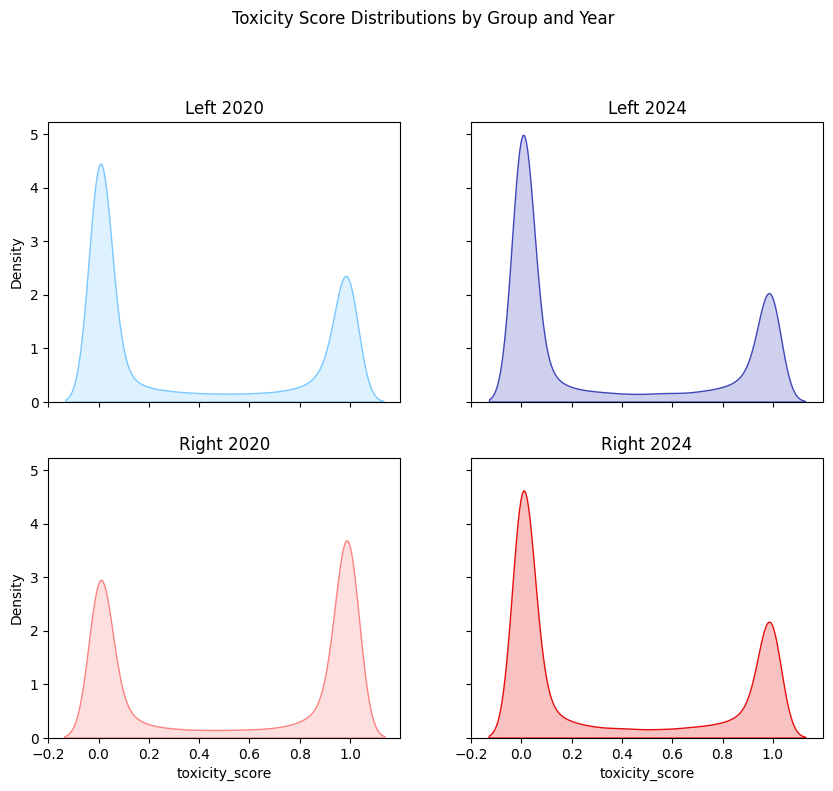

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
sns.kdeplot(df_left_2020_toxicity['toxicity_score'], fill=True, ax=axes[0,0], color="#7ac8ff")
axes[0,0].set_title(df_left_2020_toxicity['group'].iloc[0])
sns.kdeplot(df_left_2024_toxicity['toxicity_score'], fill=True, ax=axes[0,1], color="#4046B9")
axes[0,1].set_title(df_left_2024_toxicity['group'].iloc[0])
sns.kdeplot(df_right_2020_toxicity['toxicity_score'], fill=True, ax=axes[1,0], color="#fc8282")
axes[1,0].set_title(df_right_2020_toxicity['group'].iloc[0])
sns.kdeplot(df_right_2024_toxicity['toxicity_score'], fill=True, ax=axes[1,1], color="#E60F0F")
axes[1,1].set_title(df_right_2024_toxicity['group'].iloc[0])
plt.suptitle("Toxicity Score Distributions by Group and Year", y=1.02)
plt.show()


##### **Confirm Uneven Distibution with Shapiro**

In [16]:
# Define a helper function to safely test normality
def test_normality(df, group_name):
    # For large samples (>5000), Shapiro can become too sensitive, so you can test a random subset
    sample = df['toxicity_score']
    if len(sample) > 5000:
        sample = sample.sample(5000, random_state=42)
    stat, p = shapiro(sample)
    print(f"{group_name}: W={stat:.3f}, p={p:.10f}")
    if p > 0.05:
        print(" → Distribution appears normal.\n")
    else:
        print(" → Distribution is not normal.\n")

In [17]:
print(f"Test Distribution by Group:\n{'-'*45}")
for name, df in toxicityData.items():
    test_normality(df, name)

Test Distribution by Group:
---------------------------------------------
Left 2020 Election Period: W=0.720, p=0.0000000000
 → Distribution is not normal.

Left 2024 Election Period: W=0.705, p=0.0000000000
 → Distribution is not normal.

Right 2020 Election Period: W=0.733, p=0.0000000000
 → Distribution is not normal.

Right 2024 Election Period: W=0.718, p=0.0000000000
 → Distribution is not normal.



##### **Measure Central Tendency (Median) for Left and Right Groups by Election Period**

In [18]:
print(f"Median Toxicity Speech Values by Group:\n{'-'*45}")
for name, df in toxicityData.items():
    print(f"{name}:\n • Median sentiment = {df['toxicity_score'].median():.3f}")
print('-'*45)

Median Toxicity Speech Values by Group:
---------------------------------------------
Left 2020 Election Period:
 • Median sentiment = 0.058
Left 2024 Election Period:
 • Median sentiment = 0.028
Right 2020 Election Period:
 • Median sentiment = 0.800
Right 2024 Election Period:
 • Median sentiment = 0.050
---------------------------------------------


**Test Significance of Change (Mann–Whitney U)**

In [19]:
def mann_whitney_test(df1, df2, label1, label2):
    stat, p = mannwhitneyu(df1['toxicity_score'], df2['toxicity_score'])
    print(f"{label1} vs {label2}: U={stat:.2f}, p={p:.5f}")
    if p < 0.05:
        print("• Significant difference in toxicity levels.\n")
    else:
        print("• No significant difference in toxicity levels.\n")

In [20]:
# Temporal change within each group
mann_whitney_test(df_left_2020_toxicity, df_left_2024_toxicity, "Left 2020", "Left 2024")
mann_whitney_test(df_right_2020_toxicity, df_right_2024_toxicity, "Right 2020", "Right 2024")


Left 2020 vs Left 2024: U=4852848988.00, p=0.00000
• Significant difference in toxicity levels.

Right 2020 vs Right 2024: U=5611182630.00, p=0.00000
• Significant difference in toxicity levels.



**Correlation Between Toxicity and Year (Trend Analysis)**

In [21]:
# Combine data
df_toxicity_all = pd.concat([
    df_left_2020_toxicity.assign(Group='Left', YearNum=1),
    df_left_2024_toxicity.assign(Group='Left', YearNum=2),
    df_right_2020_toxicity.assign(Group='Right', YearNum=1),
    df_right_2024_toxicity.assign(Group='Right', YearNum=2)
])

# Correlation between year and hate intensity for each group
for group in ['Left', 'Right']:
    subset = df_toxicity_all[df_toxicity_all['Group'] == group]
    rho, p = spearmanr(subset['YearNum'], subset['toxicity_score'])
    print(f"{group}: Spearman ρ={rho:.3f}, p={p:.5f}")


Left: Spearman ρ=-0.048, p=0.00000
Right: Spearman ρ=-0.191, p=0.00000


#### Plots 

In [27]:
toxicity_2020 = df_2020.groupby("label")["toxicity_label"].apply(lambda x: (x == "toxic").mean() * 100)
toxicity_2024 = df_2024.groupby("label")["toxicity_label"].apply(lambda x: (x == "toxic").mean() * 100)


In [24]:
# Combine results into one DataFrame
data = pd.DataFrame({"2020": toxicity_2020,"2024": toxicity_2024}).reset_index()
# melt to long format for easy plotting
plot_data = data.melt(id_vars="label", var_name="Year", value_name="Toxicity_Percentage")
plot_data.head()

,label,Year,Toxicity_Percentage
0,Left,2020,38.257959
1,Right,2020,55.305061
2,Left,2024,33.503999
3,Right,2024,35.779309


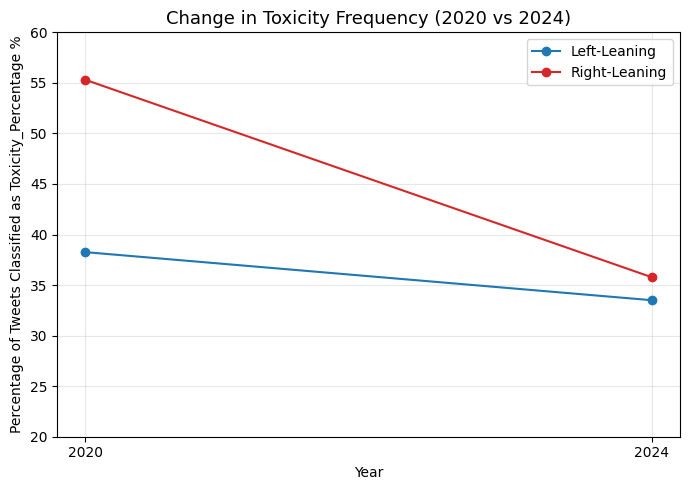

In [25]:
plt.figure(figsize=(7, 5))
for label, color in zip(["Left", "Right"], ["#1f77b4", "#d62728"]):  
    subset = plot_data[plot_data["label"] == label]
    plt.plot(subset["Year"], subset["Toxicity_Percentage"], 
             marker="o", label=f"{label}-Leaning", color=color)
plt.title("Change in Toxicity Frequency (2020 vs 2024)", fontsize=13)
plt.xlabel("Year")
plt.ylabel("Percentage of Tweets Classified as Toxicity_Percentage %")
plt.ylim(20, 60)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

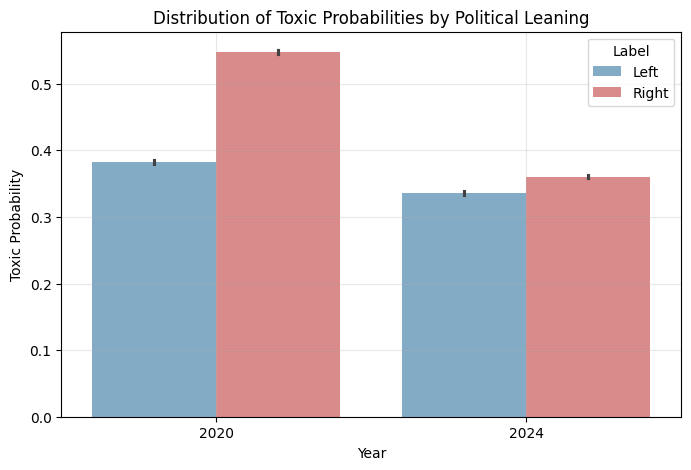

In [26]:
# combine 2020 and 2024 datasets
df_2020['Year'] = 2020
df_2024['Year'] = 2024
combined = pd.concat([df_2020, df_2024])
colors = ["Left", "Right"], ["#1f77b4", "#d62728"]
plt.figure(figsize=(8,5))
sns.barplot(data=combined, x="Year", y="toxic", hue="label", dodge=True, alpha=0.6, palette=dict(zip(*colors)))
plt.title("Distribution of Toxic Probabilities by Political Leaning")
plt.ylabel("Toxic Probability")
plt.grid(alpha=0.3)
plt.legend(title="Label")
plt.show()
